In [1]:
import math
import numpy as np
import numpy.random as npr
from numpy import linalg
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset
import torch.optim as optim
import time
from useful_tools import isPointinPolygon,polyshow,Genpoint,Distance_pol,GenBC
from network import ResNet
from math import *
torch.cuda.set_device(1)

In [2]:
def sol_exact(x):
    return torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
def sol_exact_H1(x):
    sol = torch.zeros(x.shape[0],dim_set+1).cuda()
    sol[:,0:1] = torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
    sol[:,1:dim_set+1] = pi*torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
    return sol

In [3]:
def right(x):
    return -dim_set*pi**2*torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [4]:
dim_set = 8
Batch_size = 50000
def DGM1():
    x = torch.rand(Batch_size,dim_set).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    r = model_r(x)
    v= torch.ones(u.shape).cuda()
    ux = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    loss1 = torch.sum((ux-du)**2)/Batch_size+torch.sum((r-u-du)**2)/Batch_size
    return loss1

In [5]:
def DGM2():
    x = torch.rand(Batch_size,dim_set).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    v= torch.ones(u.shape).cuda()
    uxx = torch.zeros(Batch_size,dim_set).cuda()
    for i in range(dim_set):
        ux_tem = du[:,i].reshape([x.size()[0],1])
        uxx_tem = torch.autograd.grad(ux_tem,x,grad_outputs=v,create_graph=True)[0]
        uxx[:,i] = uxx_tem[:,i]
    loss2 = torch.sum((torch.sum(uxx,dim=1).reshape([x.size()[0],1]) - right(x))**2)/Batch_size
    return loss2

In [6]:
model_u = ResNet(dim_set,20,1)
model_r1 = ResNet(dim_set,20,dim_set)

device=torch.device("cuda:1" )
model_u.to(device)
model_r1.to(device)

ResNet(
  (fc1): Linear(in_features=8, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (outlayer): Linear(in_features=20, out_features=8, bias=True)
)

In [7]:
def model_r(x):
    return x*(1-x)*model_r1(x) + torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1) + pi * torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [8]:
def model_p(x):
    return model_r(x)-model_u(x)

In [9]:
def loss_error():
    notes_error = torch.rand(10000,dim_set).cuda()
    notes_error.requires_grad= True
    exact = sol_exact_H1(notes_error)
    u_L2 = sqrt(torch.sum((exact[:,0])**2)/10000)
    Du_L2 = sqrt(torch.sum(exact[:,1:dim_set+1]**2)/10000)
    predict = torch.zeros(10000,2*dim_set+2).cuda()
    predict[:,0]= model_u(notes_error).reshape([1,notes_error.size()[0]])
    predict[:,1:dim_set+1]= model_p(notes_error)
    value1 = sqrt(torch.sum((predict[:,0] - exact[:,0])**2)/10000)/u_L2
    value2 = sqrt(torch.sum((predict[:,1:dim_set+1] - exact[:,1:dim_set+1])**2)/10000)/Du_L2
    return value1,value2

In [10]:
traintime = 50000
error_save=np.zeros([2,traintime])
optimizer = optim.Adam([
                {'params': model_r1.parameters()},
                {'params': model_u.parameters()}
            ])
i = 0
time_start=time.time()
for i in range(traintime):
    optimizer.zero_grad()
    losses = DGM1()+DGM2()
    losses.backward()
    optimizer.step() 
    error1,error2 = loss_error()
    error_save[0,i]=float(error1)
    error_save[1,i]=float(error2)
    i = i +1
    if i%500==1:
        print("i= ",i)
        print("error =",error1)
        print("loss1 =",losses.detach())
        np.save("error_save_LDG_Robin_8D_w20.npy", error_save)
np.save("error_save_LDG_Robin_8D_w20.npy", error_save)
time_end=time.time()
print('time cost',time_end-time_start,'s')

i=  1
error = 1.0195773662930316
loss1 = tensor(361.0382, device='cuda:1')
i=  501
error = 0.20277248972229384
loss1 = tensor(2.1335, device='cuda:1')
i=  1001
error = 0.1093778472154407
loss1 = tensor(0.6540, device='cuda:1')
i=  1501
error = 0.0755557379755986
loss1 = tensor(0.3810, device='cuda:1')
i=  2001
error = 0.06264177021781792
loss1 = tensor(0.2320, device='cuda:1')
i=  2501
error = 0.05722367110822304
loss1 = tensor(0.1704, device='cuda:1')
i=  3001
error = 0.05360043711869982
loss1 = tensor(0.1347, device='cuda:1')
i=  3501
error = 0.06066609632120255
loss1 = tensor(0.2259, device='cuda:1')
i=  4001
error = 0.04248364333843101
loss1 = tensor(0.1195, device='cuda:1')
i=  4501
error = 0.04488738600617212
loss1 = tensor(0.0769, device='cuda:1')
i=  5001
error = 0.04054065514432471
loss1 = tensor(0.0979, device='cuda:1')
i=  5501
error = 0.03614665188233501
loss1 = tensor(0.0686, device='cuda:1')
i=  6001
error = 0.03817280331500621
loss1 = tensor(0.0589, device='cuda:1')
i=  

In [11]:
import matplotlib.pyplot as plt
x = np.arange(0,1,0.001)
notes= torch.rand(1000,4).cuda()
notes[:,0:3] = 0
notes[:,3] = torch.tensor(x)

In [12]:
u_e = sol_exact_H1(notes)[:,0:1]
p_e = sol_exact_H1(notes)[:,1:4]

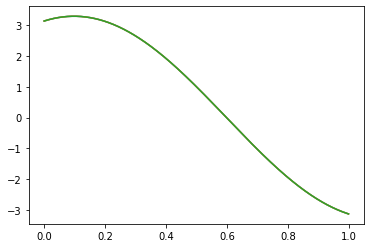

In [13]:
plt.plot(x,(u_e+p_e).cpu().detach().numpy())

In [14]:
u =  model_u(notes)
p =  model_p(notes)
r =  model_r(notes)
plt.plot(x,(r).cpu().detach().numpy())

RuntimeError: size mismatch, m1: [1000 x 4], m2: [8 x 20] at /opt/conda/conda-bld/pytorch_1587428111115/work/aten/src/THC/generic/THCTensorMathBlas.cu:283